# Evaluate a trained model

**Task:** Here we will test our tissue classifier on unseen data during training.

**This notebook will show you how to**:

- Create a dataloader for the testing data
- Load pretrained model
- Perform predictions
- Use the **confusion matrix** to see which tissue types the model is confused about
- Inspect **per-class metrics** (precision/recall) to detect underperformance
- Inspect **top scoring tiles** for qualitative insight

**Dataset**

For testing our trained model, we will use the **CRC-VAL-HE-7K** dataset, which has already been downloaded for you. This is a set of **7180** image patches from **N = 50** patients with colorectal adenocarcinoma (no overlap with patients in NCT-CRC-HE-100K). Like in the NCT-CRC-HE-100K data set, images are **224 x 224** px at **0.5** MPP. All tissue samples were provided by the NCT tissue bank, see the Zenodo link for further details and ethics statement: <br>
> Kather, J. N., Halama, N., & Marx, A. (2018). 100,000 histological images of human colorectal cancer and healthy tissue (v0.1) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.1214456



## Imports

In [2]:
from torchvision import transforms, datasets
import torch
from torch.utils.data import DataLoader

from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from cmcrameri import cm 

from model import SimpleCNN
from utils import *

In [3]:
# for faster predictions, we select gpu again
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Prepare the dataloader

In [ ]:
#data_path = "/data/horse/ws/lazi257c-come2data_workshop/data/CRC-VAL-HE-7K"
data_path = f"/tmp/{os.environ["USER"]}.nctcrc/CRC-VAL-HE-7K"

In [5]:
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std  = (0.229, 0.224, 0.225)

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

In [6]:
test_data = datasets.ImageFolder(data_path, transform=test_transform)
classes = test_data.classes
paths = [p for p,_ in test_data.samples]
print(f"Classes (N = {len(classes)}):", classes)

Classes (N = 9): ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']


In [7]:
BATCH = 64
test_loader = DataLoader(test_data, batch_size=BATCH, shuffle=False, num_workers=6)

## Load the model

In [8]:
ckpt_path = "best_model.pth"
ckpt = torch.load(ckpt_path, map_location="cpu")

In [9]:
classes = ckpt["classes"]
num_classes = len(classes)
img_size = ckpt.get("img_size", 224)

# compare if the classes the model was trained on are the same as in the test data
print(f"Classes (N = {num_classes}):", classes)
print(f"Image size: {img_size}")

Classes (N = 9): ['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']
Image size: 224


In [10]:
# now we create an instance of our model and move it to the selected device (CPU or GPU)
model = SimpleCNN(num_classes).to(device)

In [11]:
model = SimpleCNN(num_classes)
model.load_state_dict(ckpt["state_dict"])
model.to(device).eval()

SimpleCNN(
  (net): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): AdaptiveAvgPool2d(output_size=1)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=64, out_features=9, bias=True)
  )
)

## Make the predictions

In [12]:
all_probs, all_preds, all_true = [], [], []

with torch.no_grad():
    for x,y in tqdm(test_loader, desc="predicting"):
        x = x.to(device)
        logits = model(x)
        probs = logits.softmax(1).cpu()
        preds = probs.argmax(1)

        all_probs.append(probs)
        all_preds.append(preds)
        all_true.append(y)

all_probs = torch.cat(all_probs)          # (N, num_classes)
all_preds = torch.cat(all_preds)          # (N,)
all_true  = torch.cat(all_true)           # (N,)

print("Prediction completed. Number of samples:", len(all_preds))


predicting: 100%|██████████| 113/113 [00:02<00:00, 43.20it/s]

Prediction completed. Number of samples: 7180


## Quantitative metrics
First, we will plot a **confusion matrix**, which is a table that is used to evaluate the performance of a machine learning/deep learning models. The table contains information about the model's predictions on a set of data, and how those predictions compare to the actual values. The matrix is constructed by comparing the predicted labels from the model against the true labels in the test dataset. The matrix is arranged into four quadrants in case of binary (two class) classification: true positives (TP), false positives (FP), true negatives (TN), and false negatives (FN). In our case, we have a multiclass problem. Therefore, each row shows the true class and each column shows the model’s prediction. The numbers on the diagonal mean correct predictions; large values off the diagonal show which true class is being confused with which predicted class. If a row spreads across many columns the model often misclassifies that true class; if a column is bright beyond its diagonal the model over-predicts that class.

Many evaluation metrics are derived from the TP, TN, FP, FN values. To obtain them in a multiclass setting, you can pick one class and read the matrix “one-vs-rest.” The diagonal cell for that class are the **true positives (TP)**. The other cells in that row are **false negatives (FN)** (they were that class, but the model predicted something else). The other cells in that column are **false positives (FP)** (they were other classes, but the model predicted as this one). Everything not in that row or column are true negatives. 

**Precision** asks, “of what the model called this class, how many really are?” 

**Recall** asks, “of all that truly are this class, how many did we catch?” 

**Specificity** asks, “of all that are not this class, how many did we correctly reject?” 

**F1** is a single score that balances precision and recall.

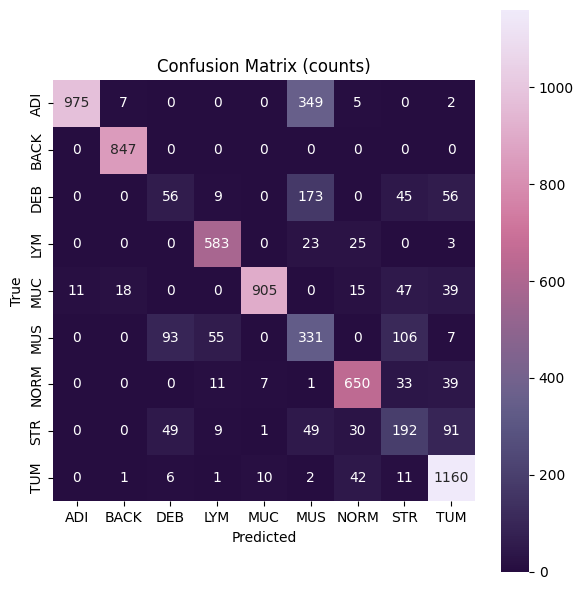

In [13]:
conf_matrix = confusion_matrix(all_true, all_preds, labels=range(len(classes)))

plt.figure(figsize=(6,6))

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap=cm.acton, cbar=True, xticklabels=classes, yticklabels=classes, square=True)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (counts)")
plt.tight_layout()
plt.show()


Next, we will use the `classification_report` function from *scikit-learn*, which returns a report containing precision, recall, f1-score, accuracy and support for each class.

"Support" here refers to the number of samples in the target that belong to each class.


In [16]:
print(classification_report(all_true, all_preds, target_names=classes, digits=4))


              precision    recall  f1-score   support

         ADI     0.9888    0.7287    0.8391      1338
        BACK     0.9702    1.0000    0.9849       847
         DEB     0.2745    0.1652    0.2063       339
         LYM     0.8728    0.9196    0.8955       634
         MUC     0.9805    0.8744    0.9244      1035
         MUS     0.3567    0.5591    0.4355       592
        NORM     0.8475    0.8772    0.8621       741
         STR     0.4424    0.4561    0.4491       421
         TUM     0.8304    0.9408    0.8821      1233

    accuracy                         0.7937      7180
   macro avg     0.7293    0.7246    0.7199      7180
weighted avg     0.8155    0.7937    0.7973      7180



As a last quantitative evaluation metric, **AU-ROC** (Area Under the Receiver Operating Characteristic Curve) is a common evaluation metric used to assess the performance of classifier models. The ROC curve is a graphical representation of the relationship between the true positive rate (TPR) and the false positive rate (FPR) at different thresholds. A classification threshold is the value used by the model to determine whether a predicted probability corresponds to a positive or negative class label. The TPR is the proportion of positive instances that are correctly classified by the model, while the FPR is the proportion of negative instances that are incorrectly classified as positive by the model. The AU-ROC value is a measure of the area under the ROC curve, and it ranges from 0 to 1. A model with an AU-ROC value of 1 indicates perfect performance, while a value of 0.5 indicates that the model performs no better than random guessing. In general, a higher AU-ROC value indicates better performance of the classifier model, and it is commonly used to compare the performance of different models. AU-ROC is a popular metric in machine learning because it is unaffected by changes in class distribution, making it a reliable way to evaluate the performance of classifier models.

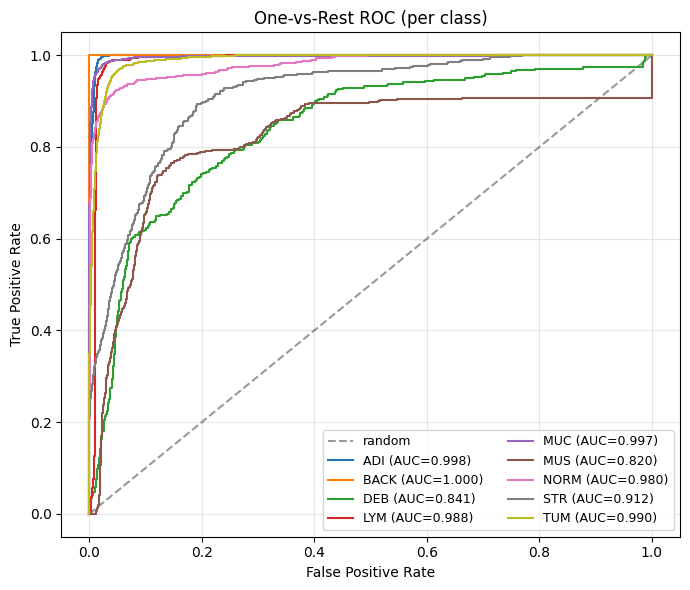

In [17]:
probs = all_probs.detach().cpu().numpy()
y_true = all_true.detach().cpu().numpy()
C = probs.shape[1]

# Binarize labels for one-vs-rest ROC
Y = label_binarize(y_true, classes=np.arange(C))

plt.figure(figsize=(7,6))
plt.plot([0,1], [0,1], 'k--', alpha=0.4, label="random")

valid_classes = 0
for k in range(C):
    yk = Y[:, k]
    fpr, tpr, _ = roc_curve(yk, probs[:, k])
    auc_k = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{classes[k]} (AUC={auc_k:.3f})")
    valid_classes += 1

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC (per class)")
plt.legend(loc="lower right", fontsize=9, ncol=2)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Basic qualitative explainability

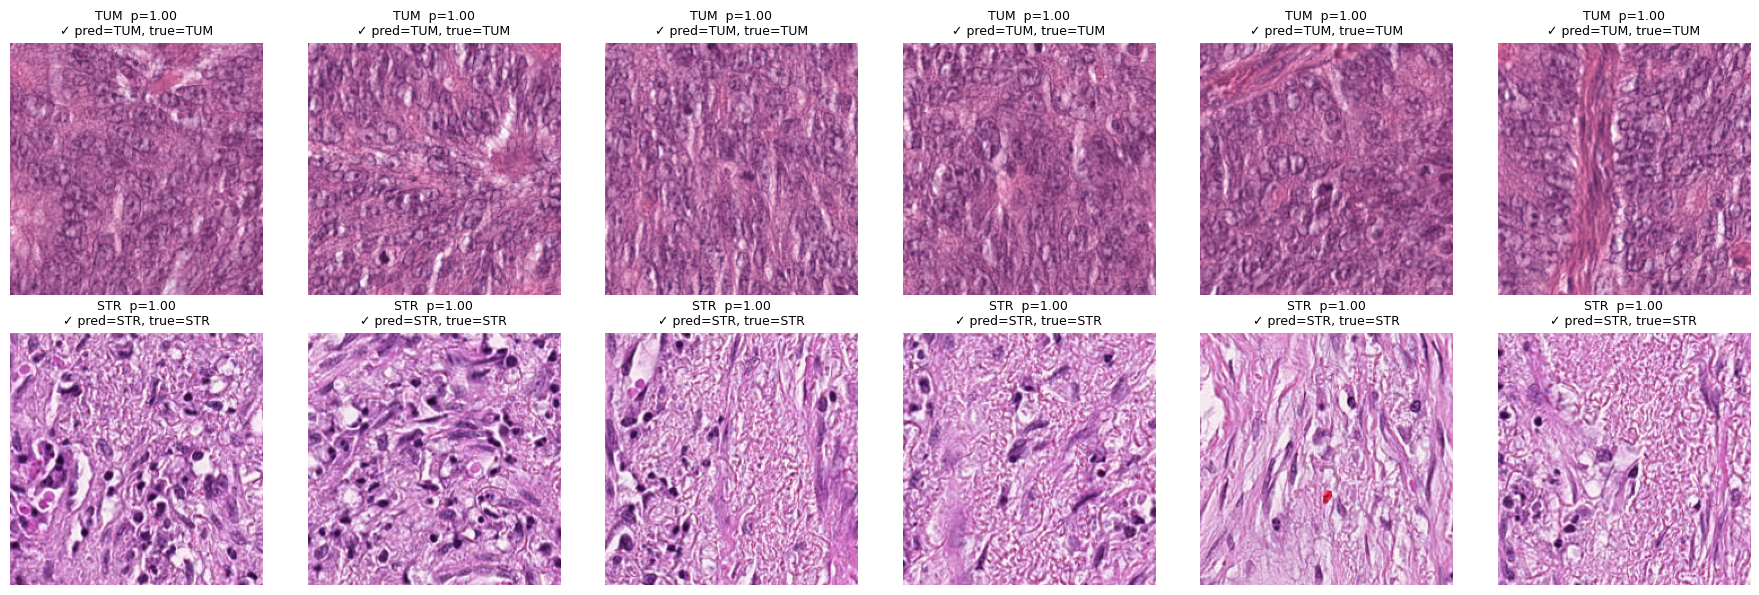

In [18]:
# Top-6 tiles most confidently scored as TUM or STR (regardless of ground truth)
show_topk_for_classes(test_data, ["TUM","STR"], all_probs, all_preds, all_true, k=6, mode="target", only=None)

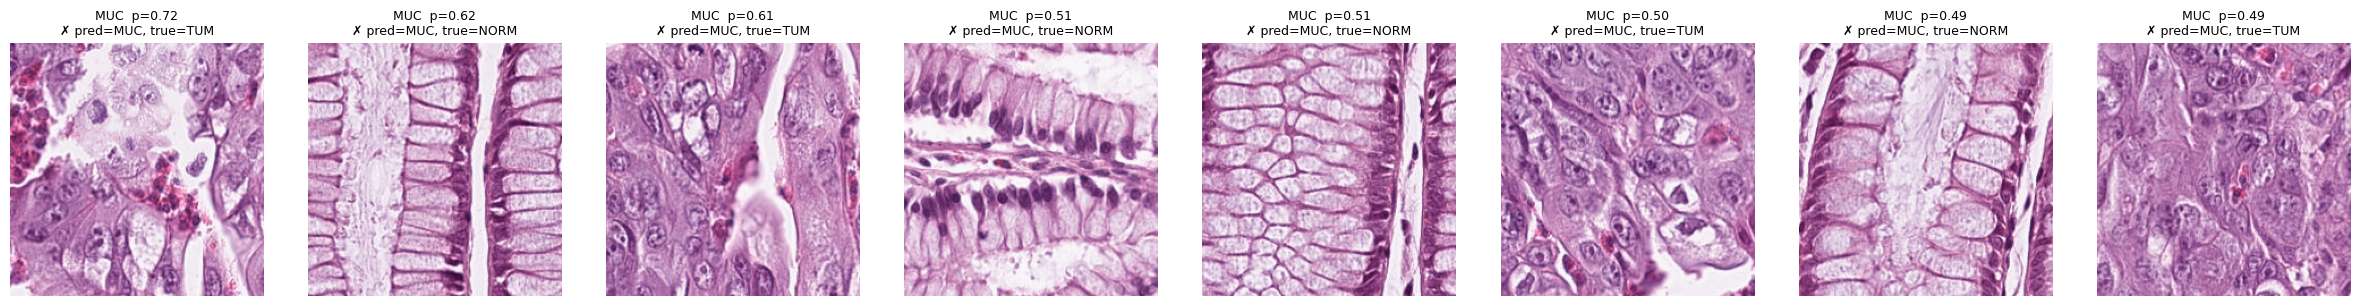

In [19]:
# Only false positives (where model predicted MUC but it was wrong)
show_topk_for_classes(test_data, ["MUC"], all_probs, all_preds, all_true, k=8, mode="pred", only="fp")

In [20]:
# Only false positives (where model predicted MUC but it was wrong)
show_topk_for_classes(test_data, ["NORM"], all_probs, all_preds, all_true, k=8, mode="pred", only="fp")